# StructN2V Denoising with the StructConvallaria Dataset
The StructConvallaria dataset consists of 100 manipulated noisy images
with enhanced structured noise patterns, derived from the original
Convallaria dataset. This notebook demonstrates StructN2V (Structured
Noise2Void) denoising, which is a self-supervised denoising method based on Noise2Void. The method was developed to remove pixel-noises from images, even in the presence of spatial noise correlations.

In [ ]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tifffile import imread, imwrite
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.config.transformations import XYFlipModel
from careamics.utils.metrics import scale_invariant_psnr
from careamics.utils import autocorrelation
from microssim import micro_structural_similarity
from PIL import Image
from careamics_portfolio import PortfolioManager

### Load the dataset
The dataset can be downloaded directly using careamics-portfolio

In [7]:
# Initialize portfolio manager
portfolio = PortfolioManager()

# Download StructConvallaria dataset
files = portfolio.denoising.StructConvallaria.download(Path("data"))
conv_stack = imread(files[0])

StructConvallaria stack shape: (100, 1024, 1024)


### Visualize the data

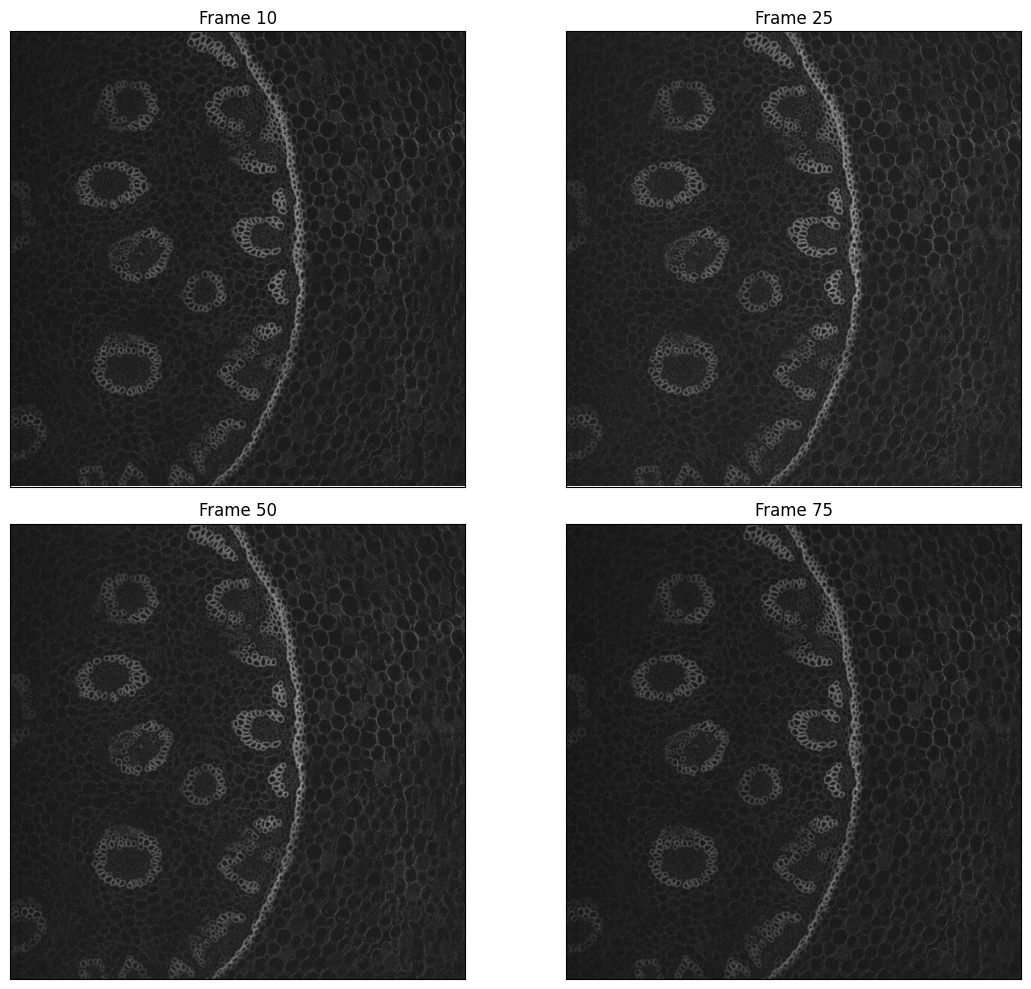

In [9]:
sample_indices = [10, 25, 50, 75]
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

for i, idx in enumerate(sample_indices):
    row = i // 2
    col = i % 2
    ax[row, col].imshow(conv_stack[idx], cmap="gray")
    ax[row, col].set_title(f"Frame {idx}")
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

plt.tight_layout()
plt.show()

We can create the ground truth, which is an average of all the frames, and select a single image for training with StructN2V.

In [10]:
# Ground truth is the average of all frames
gt_image = np.mean(conv_stack, axis=0)

# Select a single noisy image for training (frame 50)
train_image = conv_stack[50]

print(f"Ground truth shape: {gt_image.shape}")
print(f"Training image shape: {train_image.shape}")

Ground truth shape: (1024, 1024)
Training image shape: (1024, 1024)


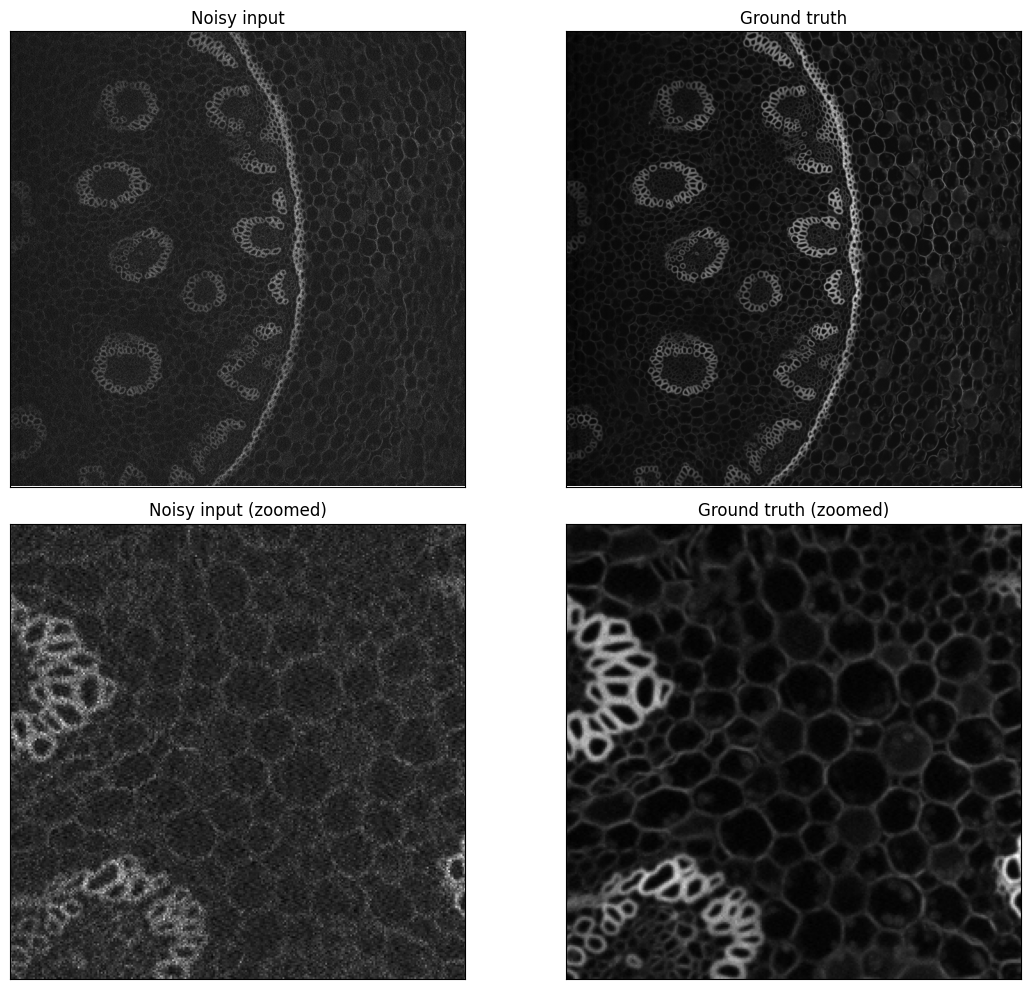

In [39]:
x_min, x_max = 256, 512
y_min, y_max = 256, 512
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Full images - top row
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].set_title("Noisy input")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(gt_image, cmap="gray")
ax[0, 1].set_title("Ground truth")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

# Zoomed regions - bottom row
ax[1, 0].imshow(train_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 0].set_title("Noisy input (zoomed)")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(gt_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 1].set_title("Ground truth (zoomed)")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.tight_layout()
plt.show()

Let's visualize the autocorrelation as well

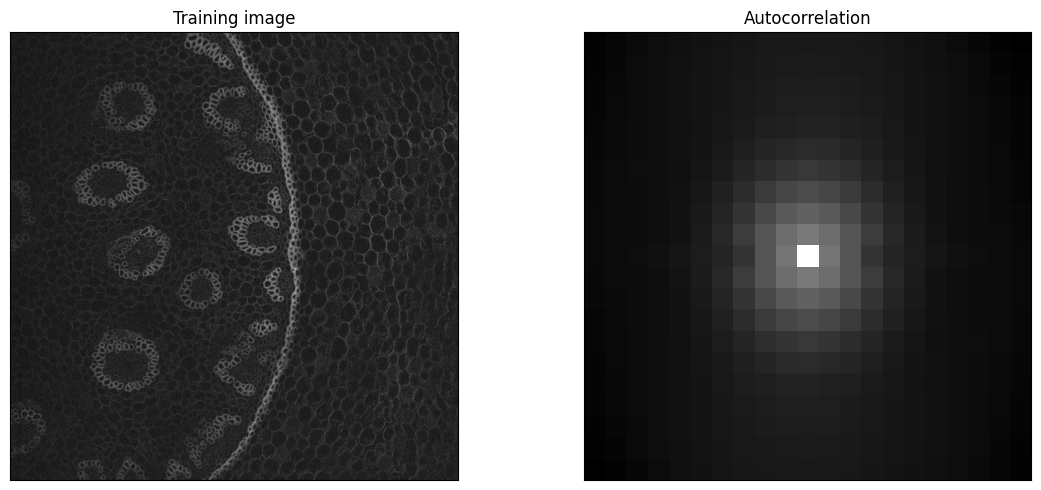

In [40]:
# Compute autocorrelation to visualize noise structure
autocorr = autocorrelation(train_image)

# Calculate center for autocorrelation slicing
center = autocorr.shape[0] // 2
slices = slice(center - 10, center + 11)

# Plot image and autocorrelation
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(train_image, cmap="gray")
ax[0].set_title("Training image")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(autocorr[slices, slices], cmap="gray")
ax[1].set_title("Autocorrelation")
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

### Create the StructN2V configuration
To use structN2V, we simply add the relevant parameters to the configuration.

In [41]:
config = create_n2v_configuration(
    experiment_name="structconvallaria_structn2v",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=16,
    num_epochs=50,
    # StructN2V parameters for handling structured noise
    struct_n2v_axis="horizontal", 
    struct_n2v_span=11,
    augmentations=[], # Disable standard augmentations due to noise correlations
)

### Initialize and train the model

In [16]:
careamist = CAREamist(source=config)

# Train the model
careamist.train(
    train_source=train_image,
    val_percentage=0.1
)

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/structn2v/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [548.40212345], std: [99.30965717]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39  

/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 15/15 [00:00<00:00, 27.34it/s, train_loss_step=0.558, val_loss=0.412, train_loss_epoch=0.495]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 15/15 [00:00<00:00, 24.38it/s, train_loss_step=0.558, val_loss=0.412, train_loss_epoch=0.495]


### Prediction with CAREamics

In [ ]:
# Predict on the training image
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

### Compute metrics

In [43]:
# Calculate metrics
psnr_noisy = scale_invariant_psnr(gt_image, train_image)
psnr_denoised = scale_invariant_psnr(gt_image, prediction[0].squeeze())

microssim_noisy = micro_structural_similarity(train_image, gt_image)
microssim_denoised = micro_structural_similarity(prediction[0].squeeze(), gt_image)

# Print results
print(f"noisy image PSNR: {psnr_noisy:.2f}")
print(f"StructN2V denoised image PSNR: {psnr_denoised:.2f}")
print(f"noisy image PSNR: {microssim_noisy:.2f}")
print(f"StructN2V denoised image PSNR: {microssim_denoised:.2f}")

noisy image PSNR: 25.40
StructN2V denoised image PSNR: 28.03
noisy image PSNR: 0.48
StructN2V denoised image PSNR: 0.64


### Visualize Prediction vs Ground Truth

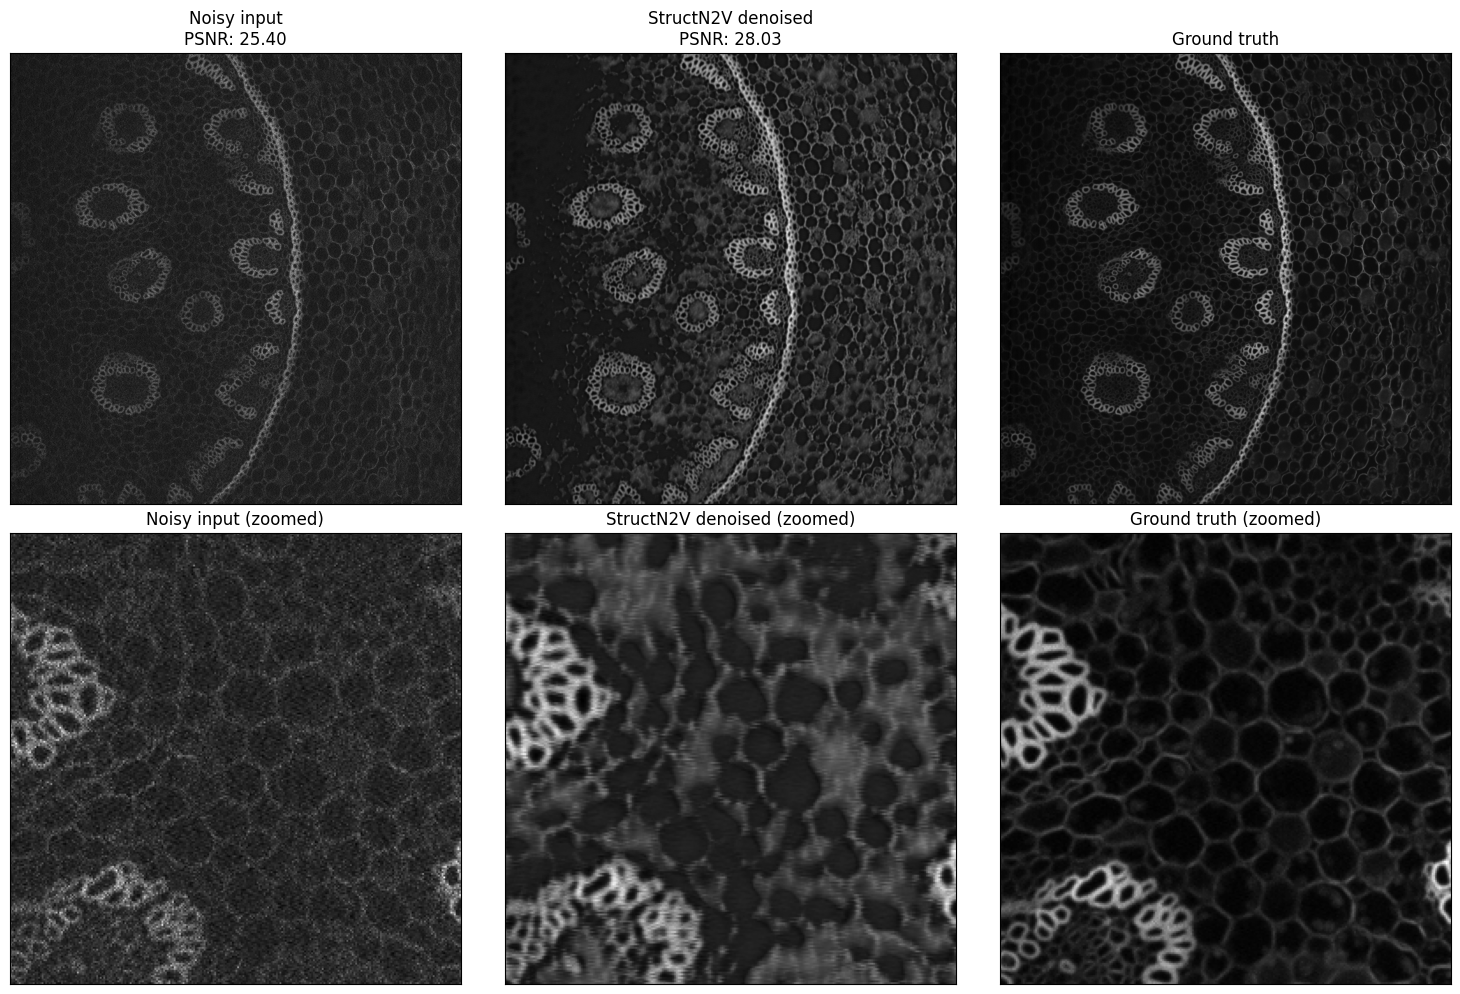

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].set_title(f"Noisy input\nPSNR: {psnr_noisy:.2f}")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(prediction[0].squeeze(), cmap="gray")
ax[0, 1].set_title(f"StructN2V denoised\nPSNR: {psnr_denoised:.2f}")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[0, 2].imshow(gt_image, cmap="gray")
ax[0, 2].set_title("Ground truth")
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

# Zoomed regions - bottom row
ax[1, 0].imshow(train_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 0].set_title("Noisy input (zoomed)")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(prediction[0].squeeze()[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 1].set_title("StructN2V denoised (zoomed)")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

ax[1, 2].imshow(gt_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 2].set_title("Ground truth (zoomed)")
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

plt.tight_layout()
plt.show()

### Get training losses

{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


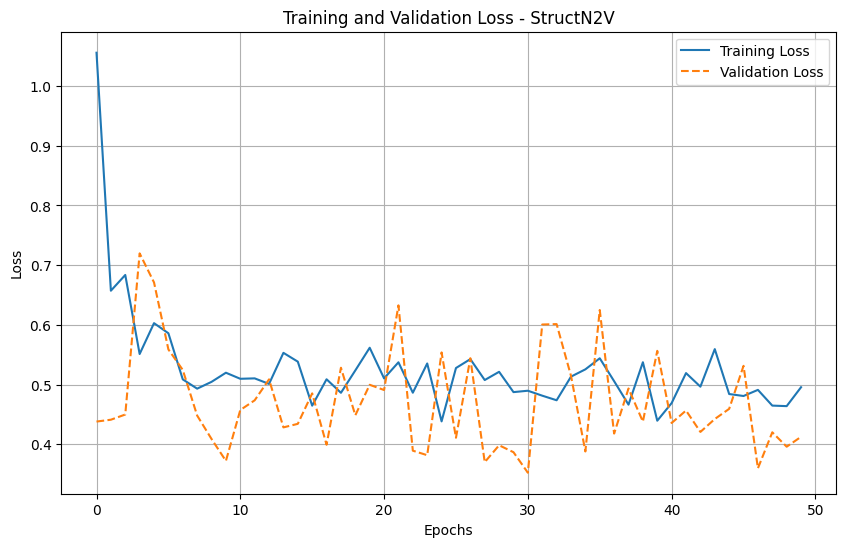

In [34]:
# Retrieve the training and validation losses
losses = careamist.get_losses();

# Extract train and validation losses
train_losses = losses.get('train_loss', [])
val_losses = losses.get('val_loss', [])

train_epochs = list(range(len(train_losses)))
val_epochs = list(range(len(val_losses)))

# Plot the losses
plt.figure(figsize=(10, 6))
if train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss')
if val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - StructN2V')
plt.grid(True)
plt.legend()
plt.show()

### And you're done! Let's create a cover

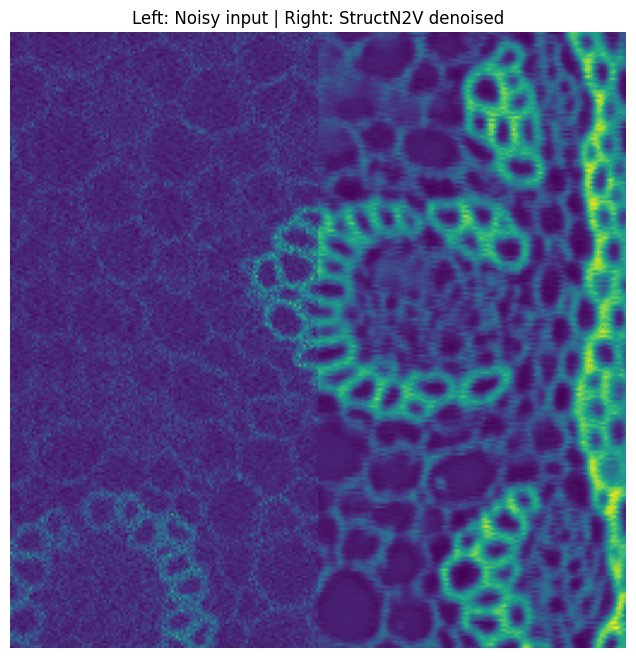

In [37]:
# Create a cover image 
x_start, width = 400, 256
y_start, height = 350, 256

cover = np.zeros((height, width))
norm_train = (train_image - train_image.min()) / (train_image.max() - train_image.min())
norm_pred = (prediction[0].squeeze() - prediction[0].squeeze().min()) / (prediction[0].squeeze().max() - prediction[0].squeeze().min())

# Extract the SAME region from both images
region_train = norm_train[y_start:y_start+height, x_start:x_start+width]
region_pred = norm_pred[y_start:y_start+height, x_start:x_start+width]

# Split each region in half and combine
cover[:, :width//2] = region_train[:, :width//2]  
cover[:, width//2:] = region_pred[:, width//2:]  

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(cover, cmap="viridis")
plt.title("Left: Noisy input | Right: StructN2V denoised")
plt.axis('off')
plt.savefig("StructConvallaria_StructN2V_cover.jpg", dpi=300, bbox_inches='tight')
plt.show()

# Save raw image
from PIL import Image
im = Image.fromarray((cover * 255).astype(np.uint8))
im.save("StructConvallaria_StructN2V.jpeg")

### Export the model to BMZ format

In [25]:
# Define model descriptions
general_description = (
    "This model is a UNet trained using the StructN2V algorithm to denoise images. "
    "StructN2V is a variant of Noise2Void that can remove 1D structured noise, the "
    "main failure case of the original N2V. The training data consists of a single "
    "image from the StructConvallaria dataset with enhanced structured noise patterns. "
    "The notebook used to train this model is available on the CAREamics documentation."
)

data_description = (
    "StructConvallaria dataset with enhanced structured noise patterns. "
    "The data consists of 100 images derived from the original Convallaria dataset, "
    "specifically manipulated to contain more structured noise correlations for "
    "testing StructN2V capabilities."
)

# Export the model
careamist.export_to_bmz(
    path_to_archive="structconvallaria_structn2v_model.zip",
    friendly_model_name="StructConvallaria_StructN2V",
    input_array=train_image.astype(np.float32),
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
    general_description=general_description,
    data_description=data_description,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

Your CAREamics version seems to be a locally modified version (0.0.12.dev13+gce27d0d). The recorded version for loading models will be 0.0.12, which may not exist. If you want to ensure exporting the model with an existing version, please install the closest CAREamics version from PyPI or conda-forge.
Your CAREamics version seems to be a locally modified version (0.0.12.dev13+gce27d0d). The recorded version for loading models will be 0.0.12, which may not exist. If you want to ensure exporting the model with an existing version, please install the closest CAREamics version from PyPI or conda-forge.


computing SHA256 of inputs.npy (result: f107951e7b7860117ff4f40501aee64acc15f6cdba7bf83876f7be31a7d50274): 100%|██████████| 4194432/4194432 [00:00<00:00, 1005815728.97it/s]
computing SHA256 of outputs.npy (result: 21010e39931d03e83ad4e65b19abfc1485eed5df64644d0440b6e138a44af939): 100%|██████████| 4194432/4194432 [00:00<00:00, 1047497643.07it/s]
computing SHA256 of environment.yml (result: bbf164cd3dd96acb2abdceede0c319cf29488ba6d51d34fae21d44c31f65d76a): 100%|██████████| 131/131 [00:00<00:00, 247613.26it/s] 
computing SHA256 of weights.pth (result: db016b56e0222db624ceb4c0998190ee0ef0eb380a83131b3126a6fa6307796f): 100%|██████████| 2066750/2066750 [00:00<00:00, 936940963.25it/s] 
computing SHA256 of careamics.yaml (result: 2e8b8484ad0787d944e3a7587d6b9b85998ea7455368f819e738fd1855b4f160): 100%|██████████| 1333/1333 [00:00<00:00, 2258992.82it/s] 
2025-06-23 17:50:35.551 | Level 30 | bioimageio.spec.model.v0_5:_validate_documentation:2106 - documentation: No '# Validation' (sub)section fo